In [153]:
import pandas as pd 
import numpy as np 
from collections import Counter 
import matplotlib.pyplot as plt
from PreLoader import PreLoader
import ArrayGenerator
from tsai.all import *

In [154]:
df = pd.read_pickle(r"datasets\vhr_graduation_project_all.pickle")
df.head(1)

,name,date,status,rpm,bearing_abbs,standardized_faults,report_name,zone,area,factory,type,ts_shape_no_nans,ts
0,Main Fan A(F-005A),2022-01-20,hmv,1476.6,{},"[Misalignment,machine, SoftFoot,motor, BaseProblems,motor, BaseProblems,motor, BeltProblem,machine, BaseProblems,machine, CockedBearing,machine, Looseness,machine, Misalignment,machine, XC,machine, BaseProblems,motor, SoftFoot,motor]",RTC220055-9004934-Line 4-F-005A-V001-D-36-3101-22-6144.docx,AZFC Zone 4,New Numan Mill,AZFC,vhr,"(12, 8192)","[[-0.01095184, -0.011836081, -0.012565245, -0.012270509, -0.012300278, -0.013320656, -0.013026895, -0.012533905, -0.013063409, -0.012450588, -0.011686881, -0.012133516, -0.011509651, -0.011013504, -0.01114404, -0.010445369, -0.009850427, -0.01007186, -0.009217497, -0.008727451, -0.008961891, -0.008416777, -0.007894184, -0.008172687, -0.008083154, -0.007089157, -0.006830435, -0.006774916, -0.005936872, -0.005677863, -0.005666965, -0.004578024, -0.004122706, -0.003228867, -0.001870759, -0.001284106, -0.000899825, 0.000474368, 0.000831867, 0.001056994, 0.002552633, 0.003245881, 0.002865068, 0..."


In [155]:
X = np.array(df["ts"].to_list())
y = np.array(df["standardized_faults"])
X.shape, y.shape

((217, 12, 16384), (217,))

In [156]:
X, y = ArrayGenerator.generate_dataset_array(dataset_category=1, ts=X, labels=y, split_method="channel")

{'Faults classified': 'AirGap, Electrical and SoftFoot problems', 'Channels taken': 'Motor channels only', 'Labels array': 'Binary'}


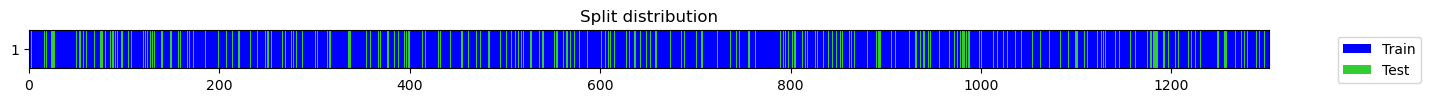

In [157]:
report_splits = get_splits(y, valid_size=0.2, shuffle=True)

In [158]:
X_train, y_train = X[report_splits[0]], y[report_splits[0]]
X_test, y_test = X[report_splits[1]], y[report_splits[1]]

In [159]:
X_train, y_train = ArrayGenerator.apply_sliding_window(X_train, y_train, window_size=4096, with_fft=True, overlap_pct=0.8)
X_test, y_test = ArrayGenerator.apply_sliding_window(X_test, y_test, window_size=4096, with_fft=True, overlap_pct=0)

valid == train


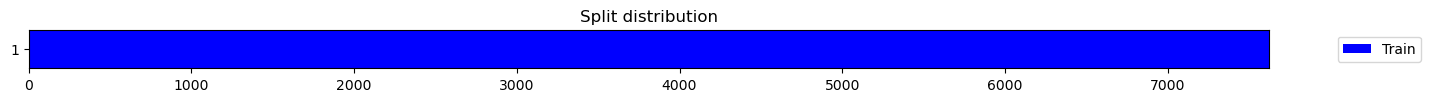

Counter({0: 6045, 1: 6045})

In [160]:
train_balance_splits = get_splits(y_train, valid_size=0, balance=True, strategy="oversample", shuffle=True)
X_train, y_train = X_train[train_balance_splits[0]], y_train[train_balance_splits[0]]
Counter(y_train)

In [161]:
X, y, splits = combine_split_data([X_train, X_test], [y_train, y_test]) 

In [162]:
tfms  = [None, [TSStandardize(by_var=False), Categorize()]]
batch_tfms = [TSStandardize(by_var=False)]
dls = get_ts_dls(X, y, splits=splits, tfms=tfms, shuffle_train=True, batch_tfms=batch_tfms, bs=[32,256])

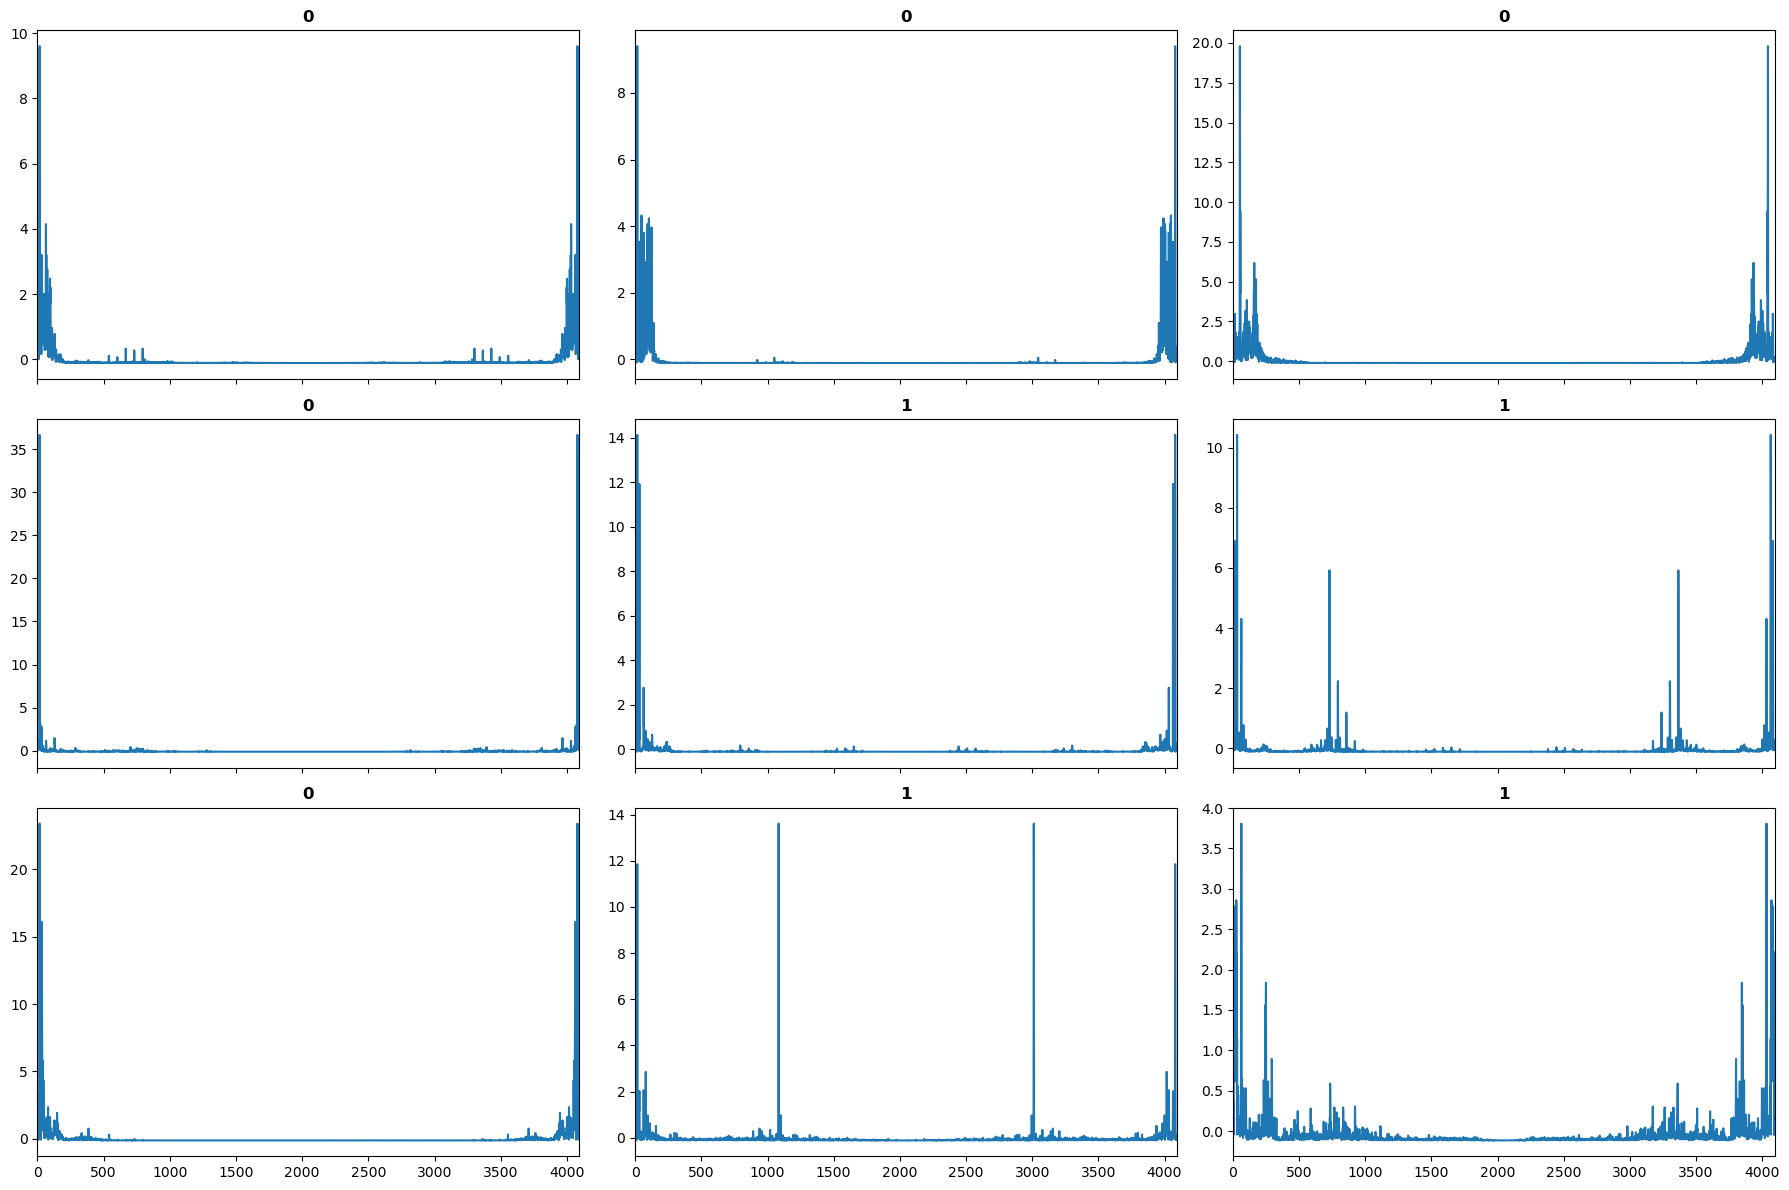

In [163]:
dls.show_batch(sharex=True) 

In [168]:
model = MLP(dls.vars, dls.c, seq_len=X_train.shape[-1], layers=[16], ps=[0], use_bn=True)
learn = Learner(dls, model, metrics=[accuracy, Precision(), Recall(), F1Score(), BalancedAccuracy()])

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,balanced_accuracy_score,time
0,0.137391,0.204874,0.907524,0.779661,0.873418,0.823881,0.896084,00:02
1,0.067945,0.188599,0.916928,0.803468,0.879747,0.839879,0.904457,00:02


,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,balanced_accuracy_score
1,0.067945,0.188599,0.916928,0.803468,0.879747,0.839879,0.904457


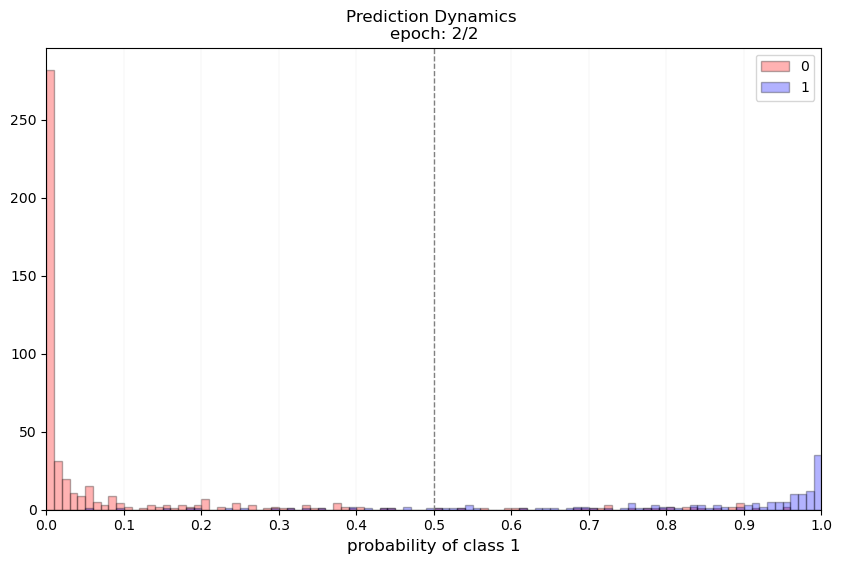

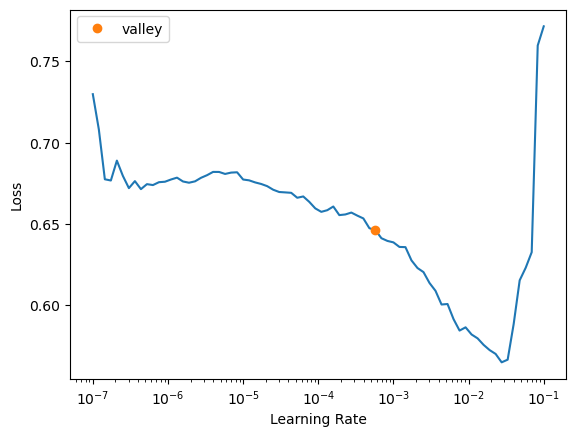

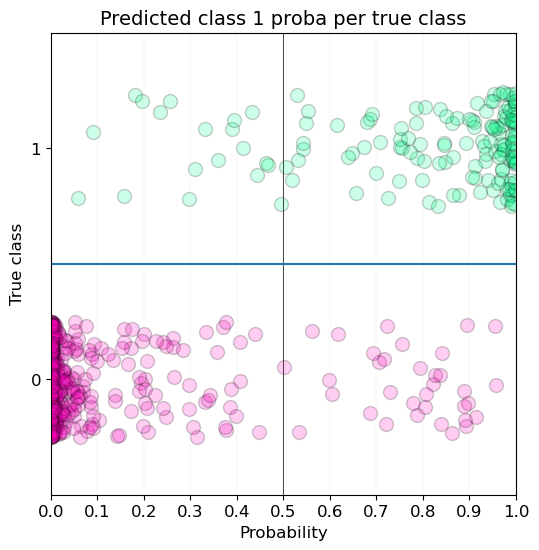

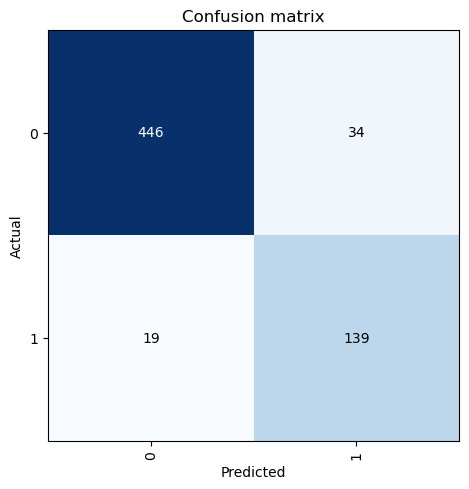

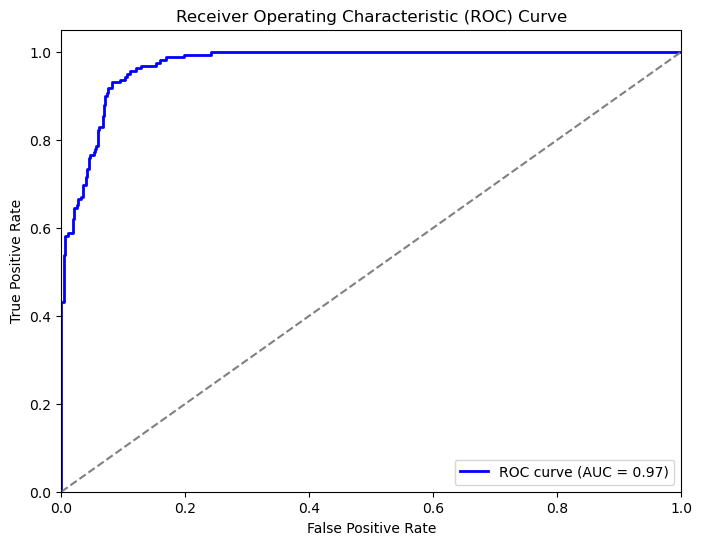

In [169]:
learn.fit_one_cycle(2, lr_max=learn.lr_find(), cbs=[PredictionDynamics()]) 
learn.show_probas()
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
valid_dl = dls.valid
valid_probas, valid_targets, valid_preds = learn.get_preds(dl=valid_dl, with_decoded=True)
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

positive_probs = valid_probas[:, 1]
#Draw ROC curve to help us adjust the threshold to a better value.
fpr, tpr, thresholds = roc_curve(valid_targets, positive_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
